In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

from skimage import color, io
from skimage.transform import rescale
import time
import tqdm

In [2]:
def generate_object(num_angles=3, convex=True):
    angles = np.random.random(num_angles).cumsum()
    angles = (angles / angles[-1]) * np.pi * 2
    if convex:
        xs, ys = np.cos(angles) * 2, np.sin(angles) * 2
    else:
        coefs = np.random.random(num_angles) + 1
        xs, ys = coefs * np.cos(angles), coefs * np.sin(angles)
    for i in range(len(xs)):
        ip1, ip2 = (i + 1) % len(xs), (i + 2) % len(xs)
        vec1 = np.array([xs[ip1]-xs[i], ys[ip1]-ys[i]])
        vec2 = np.array([xs[ip2]-xs[ip1], ys[ip2]-ys[ip1]])
        cos = np.inner(vec1, vec2) / \
            (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        dist = np.linalg.norm(vec1)
        if np.abs(cos) > 0.89 or dist < 0.5:
            return generate_object(num_angles, convex)
    return xs, ys

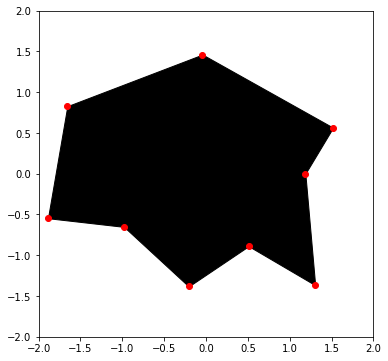

In [115]:
xs, ys = generate_object(num_angles=9, convex=False)

N = np.stack((xs, ys)).transpose(1, 0)
patches = [Polygon(N)]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
p = PatchCollection(patches, alpha=1, color="k")
ax.add_collection(p)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot(xs, ys, "ro")
plt.show()

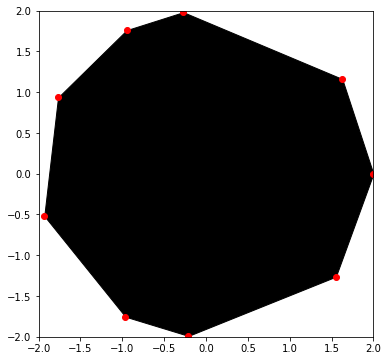

In [120]:
xs, ys = generate_object(num_angles=9, convex=True)

N = np.stack((xs, ys)).transpose(1, 0)
patches = [Polygon(N)]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
p = PatchCollection(patches, alpha=1, color="k")
ax.add_collection(p)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot(xs, ys, "ro")
plt.show()

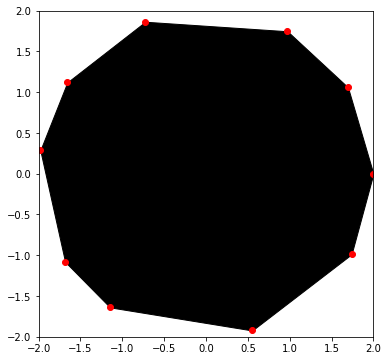

In [121]:
xs, ys = generate_object(num_angles=10, convex=True)

N = np.stack((xs, ys)).transpose(1, 0)
patches = [Polygon(N)]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
p = PatchCollection(patches, alpha=1, color="k")
ax.add_collection(p)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot(xs, ys, "ro")
plt.show()

In [58]:
images = [[] for i in range(8)]
for j in tqdm.tqdm(range(8)):
    for i in range(1200):
        xs, ys = generate_object(num_angles=j+3, convex=True)
        N = np.stack((xs, ys)).transpose(1, 0)
        patches = [Polygon(N)]

        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        p = PatchCollection(patches, alpha=1, color="k")
        ax.add_collection(p)

        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.axis("off")
        plt.savefig("fig.png", dpi=300)
        plt.close(fig)

        img = color.rgb2gray(io.imread("fig.png"))
        img = rescale(img, 0.5)
        images[j].append(1-img)

100%|██████████| 8/8 [21:52<00:00, 165.06s/it]


In [132]:
tr = np.load("data/convex_clean_test.npz")
tr_dat, tr_lab = tr["data"], tr["labels"]

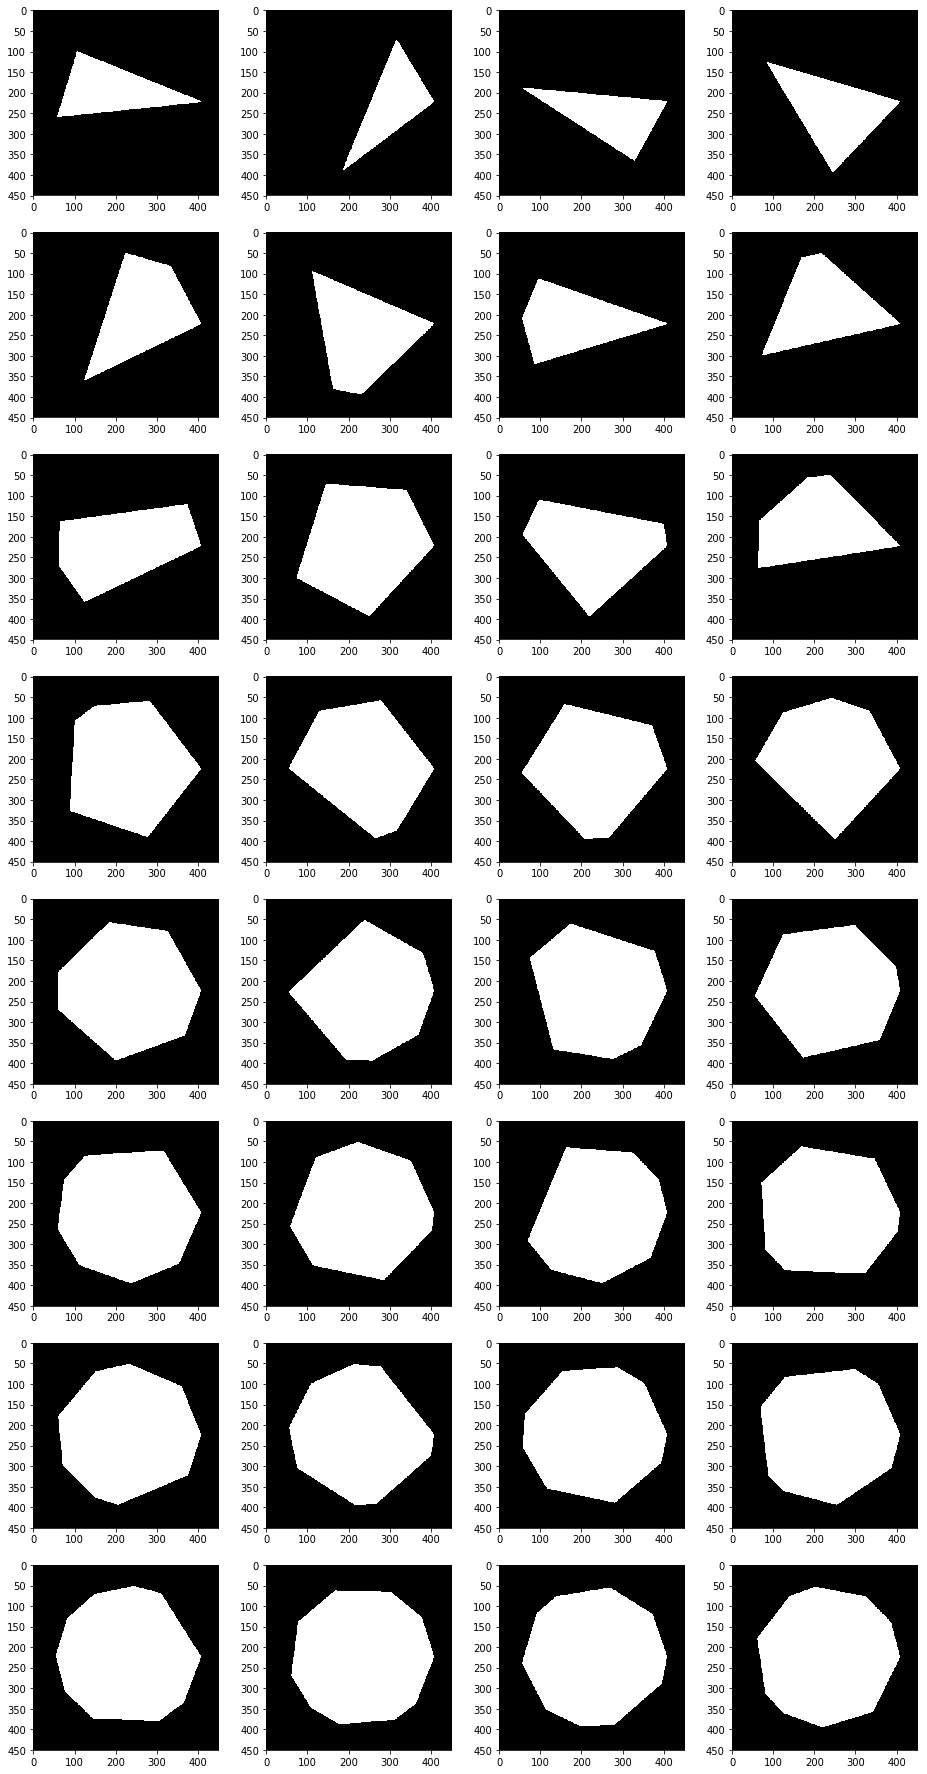

In [133]:
fig, ax = plt.subplots(8, 4, figsize=(16, 32))
for i in range(8):
    for j in range(4):
        idx = np.random.randint(200) + 200 * i
        ax[i,j].imshow(tr_dat[idx], cmap="gray")

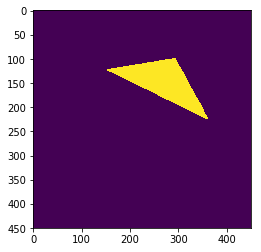

In [89]:
plt.imshow(tr[100])

In [94]:
img = tr[100]
stats = []
x = 3
for i in range(450-x):
    for j in range(450-x):
        stat = np.sum(img[i:i+x,j:j+x])
        if stat > 0 and stat < x ** 2:
            stats.append(stat)

(array([197., 188., 111., 182., 184., 109., 373.]),
 array([1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 7 Patch objects>)

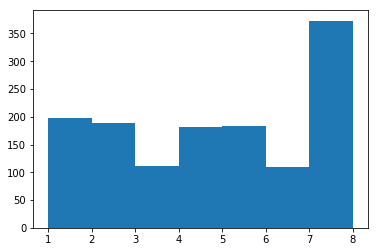

In [95]:
plt.hist(stats, bins=x**2-2)

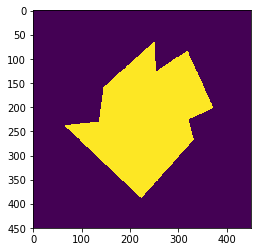

In [44]:
plt.imshow(test[-4])

In [60]:
data = np.array(images).astype(np.bool)
train = data[:,:1000].reshape(-1, 450, 450)
labels = np.repeat(np.arange(8), 1000)
np.savez("data/convex_clean_train.npz", data=train, labels=labels)

test = data[:,1000:1200].reshape(-1, 450, 450)
labels = np.repeat(np.arange(8), 200)
np.savez("data/convex_clean_test.npz", data=test, labels=labels)

In [20]:
data = np.load("data.npz")["data"]
train = data[:7, :1000].reshape(-1, 225, 225)
labels = np.repeat(np.arange(7), 1000)
np.savez("data/train.npz", data=train, labels=labels)

test = data[:7, 1000:1200].reshape(-1, 225, 225)
labels = np.repeat(np.arange(7), 200)
np.savez("data/test.npz", data=test, labels=labels)

In [ ]:
np.savez("data.npz", data=ims)

In [ ]:
images[-1][3]

In [15]:
tr = np.load("data/clean_train.npz")["data"]
tr.shape

(8000, 450, 450)

In [26]:
np.savez("small_data.npz", train=train, test=test)

In [85]:
test = np.load("small_data.npz")["test"]
labels = np.repeat(np.arange(7), 200)

In [87]:
np.savez("data/test.npz", data=test.reshape(-1, 225, 225), labels=labels)

In [100]:
t = np.load("data/train.npz")["data"]

In [101]:
t.shape

(21000, 225, 225)

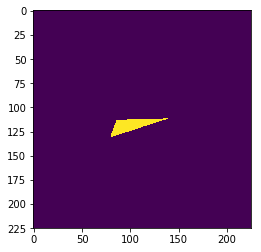

In [65]:
plt.imshow(t[0])

In [64]:
t.shape

(7000, 225, 225)

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

In [7]:
train_loader

In [45]:
ll = torch.utils.data.DataLoader("data/train.npz")

In [53]:
from torch.utils.data import Dataset, Sampler, DataLoader

In [66]:
class CorpusDataset(Dataset):
    def __init__(self, data_path):
        t = np.load(data_path)
        self.data, self.labels = t["data"], t["labels"]
        self.data = self.data.astype(np.uint8)
        self.labels = self.labels.astype(np.uint8)
        self.len = self.data.shape[0]

    def __getitem__(self, index):
        img, lbl = self.data[index], self.labels[index]
        dct = {"images": img, "labels": lbl}
        return dct

    def __len__(self):
        return self.len


class CorpusSampler(Sampler):
    def __init__(self, dataset):
        self.dataset = dataset
        self.len = len(self.dataset)
        self.indices = np.arange(self.len)
        np.random.shuffle(self.indices)

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return self.len

In [75]:
ds = CorpusDataset("data/train.npz")

In [68]:
sl = CorpusSampler(ds)

In [76]:
train_loader = DataLoader(
    dataset=ds,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory="cuda",
)

In [77]:
for batch in train_loader:
    break

In [79]:
batch["labels"]

tensor([2, 6, 0, 5, 1, 5, 4, 3, 2, 5, 4, 4, 6, 4, 5, 1, 1, 3, 1, 0, 5, 0, 0, 4,
        1, 3, 3, 2, 6, 6, 1, 0], dtype=torch.uint8)

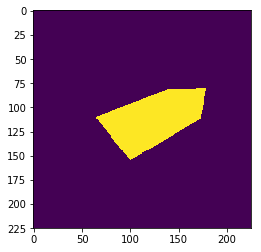

In [80]:
plt.imshow(batch["images"][0])

In [ ]:
nn.Conv2d